<a href="https://colab.research.google.com/github/TimilsinaSushil/Thesis/blob/DNN/DNN_applied_k_fold_to_coarse_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.3.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install inltk
!pip install nepali-stemmer

In [6]:
from inltk.inltk import setup
from inltk.inltk import tokenize
from inltk.inltk import get_embedding_vectors
from nepali_stemmer.stemmer import NepStemmer
# setup('ne')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('QSN.csv')

Saving QSN.csv to QSN.csv


['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


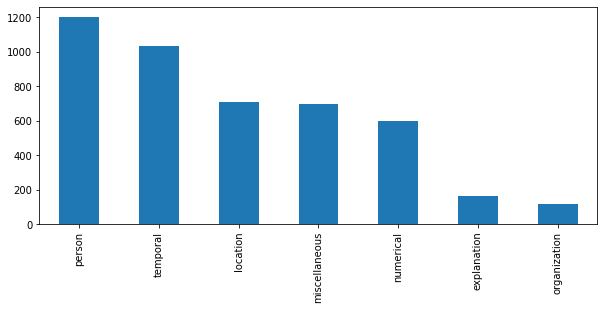

In [8]:
#coarse type filtering
df=df[df['CoarseType'].isin(['location','temporal','numerical','person','organization','explanation','miscellaneous'])]
coarse_type=df['CoarseType'].unique()
print(coarse_type)
plt.figure(figsize=(10,4))
df.CoarseType.value_counts().plot(kind='bar');


**Text Preprocessig**

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
#removing text inside brackets and quotes
import re
def removeTextInsideQuotesAndBrackets(text):
  text=re.sub("[\(\[].*?[\)\]]", "", text)
  text=re.sub("\'.*?\'","",text)
  text=re.sub('\".*?\"',"",text)
  return text

In [11]:
def removeKo(text):
  words= text.split()
  text=[]
  for word in words:
    length=len(word)
    if(length > 2):
      if(word[-2]=='क' and word[-1]=='ो'):
        if(word!='कसको'):
          word= word[:length-2]
    text.append(word)
  text=' '.join([word for word in text])
  # print(text)
  return text




In [12]:
def preprocessing(questions):
  questions=questions.apply(removeTextInsideQuotesAndBrackets)
  questions = questions.apply(removeKo)
  #tokenization
  questions= questions.apply(lambda x: tokenize(x,'ne'))
  #removing duplicates
  questions= questions.apply(lambda x: list(dict.fromkeys(x)))
  
  questions=questions.apply(lambda x: ' '.join(x).replace('▁','').split())
  questions=questions.apply(lambda x: ' '.join(x))

  #removing numbers
  questios=questions.apply(lambda x: ''.join(c for c in x if not c.isdigit()))
  #removing punctuation
  punctuation=['!','"','#','$','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',"]",'^','_','`','{','|','}','~']
  questions = questions.apply(lambda x: ''.join(c for c in x if c not in punctuation))

  #removing stopwords
  WHWORDS = ['कुन','कहिले','के','कति','को','कसले','कहाँ','कसलाई','कसको','कस्तो','कति','कसरी','किन','कता']
  STOPWORDS = stopwords.words('nepali')
  # Removig WH words from STOPWORDS
  for word in WHWORDS:
    if word in STOPWORDS: STOPWORDS.remove(word)

  STOPWORDS=set(STOPWORDS)
  def clean_text(text):
      text=' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
      return text
  questions = questions.apply(clean_text)
  return questions



In [ ]:
#stemmig
# nepstem = NepStemmer()
# df['Questions'] = df['Questions'].apply(nepstem.stem)
# df.head(10)

In [13]:
df['Questions'] = preprocessing(df['Questions'])

dataset=df

df.head()

,Questions,Answer,CoarseType,FineType,WhWord,Domain
0,नेपाली क्रिकेट टिम क्याप्टेन ज्ञानेन्द्र मल्ल ...,वि.सं. २०७६ कार्तिक १३,temporal,date,कहिले,Sports
1,फ्रान्स लियोन सम्पन्न महिला विश्वकप फुटबल २०१९...,अमेरिका,location,country,कसले,Sports
2,विश्व शान्ति सू चा ंक २०१९ नेपाल कति औ स्थानमा...,७६ औ स्थानमा,numerical,rank,कति,Miscellaneous
3,फलफूल बोट रु दश नोट कार्यक्रम सुरुवात कुन जिल्...,"इच्छाकामना गाउँपालिका, चितवन",location,city,कुन,Politics
4,माथिल्लो त्रिशुली थ्री जल विध ुत आयोजना विधुत ...,वि.स. २०७६ जेठ ०२,temporal,date,कहिले,Miscellaneous


*The topology of a neural network that classifies text is somewhat different than that of the networks presented thus far. It still has a dense layer (or layers), and it still has a sigmoid output layer with one neuron for binary classification or a softmax output layer with one neuron per class for multiclass classification. But preceding those layers are an embedding layer and a flatten layer. The former uses word embeddings to transform arrays, or sequences, of scalar values representing words into arrays of word vectors, which encode information about relationships between words. The latter “flattens” the 2D arrays output by the embedding layer into 1D arrays that can be input to a dense layer.*

In [14]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Questions'])
sequences = tokenizer.texts_to_sequences(df['Questions'])
# print(sequences)

*Neural network expects all sequences to be the same length. Keras’s pad_sequences function performs this final step, truncating sequences longer than the specified length and padding sequences shorter than the specified length with 0s:*

In [15]:
from keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences, maxlen=100)
print(padded_sequences)

[[   0    0    0    0 ... 1101  104    3  227]
 [   0    0    0    0 ...   56    7   63  201]
 [   0    0    0    0 ...    4  414  148   26]
 [   0    0    0    0 ...    1   72  237  958]
 ...
 [   0    0    0    0 ... 2085 3368   13  252]
 [   0    0    0    0 ...    4  355 3367  246]
 [   0    0    0    0 ...  528  144 1141   36]
 [   0    0    0    0 ...  528  144 1141   36]]


*The first hidden layer in a neural network that classifies text is an embedding layer whose job is to convert padded sequences of word indices into arrays of word vectors, which represent each word with an array of floating-point numbers rather than a single integer. Each word in the input text is represented by a vector in the embedding layer, and as the network is trained, vectors representing individual words are adjusted to reflect their relationship to one another. If you’re building a sentiment-analysis model and words such as “excellent” and “amazing” are generally associated with positive sentiment, then the vectors representing those words in the embedding space should be relatively close together so phrases such as “excellent service” and “amazing service” score similarly*

**One hot encoding of labels**

In [16]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
y=df.CoarseType;
print(y.unique())
y = le.fit_transform(y)
y = to_categorical(y) 

['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


**Coarse Grained Classification**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 128)               409728    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 730,631
Trainable params: 730,631
Non-trainable params: 0
_________________________________________________________________
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [   9   11   12   14 ... 3579 3583 3603 3606]
Epoch 1/10
137/137 [==============================] - 2s 11ms/step - lo

Text(48.49999999999999, 0.5, 'Actual label')

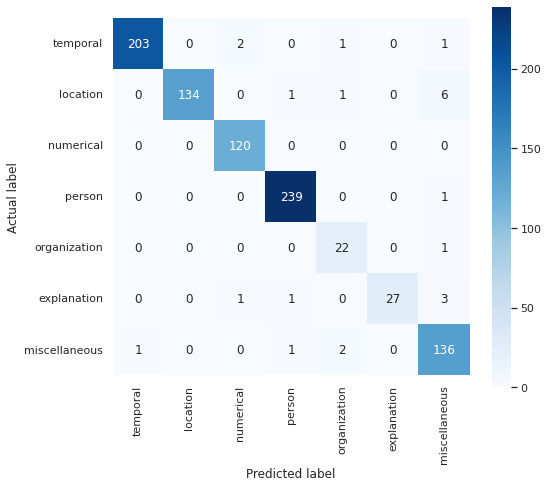

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



x=padded_sequences;
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.20) 
metrics = []
skf= StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
# x=np.array(x_train)
# y=np.array(y_train)


# from keras.optimizers import Adam
model = Sequential() 
model.add(Embedding(10000, 32, input_length=100)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) 
#default value of learning rate will be 0.001
#adam is a variant of SGD(Sochastic gradient descent). Learning rate should be between (0.0001 to 0.1).Objective: Minimize the loss between actual output and predicted output.
model.optimizer.lr=0.002
model.summary()

# K fold cross validation
for train_index, validation_index in skf.split(x_train, y_train.argmax(1)):
    print("TRAIN:", train_index, "VALIDATION:", validation_index)
    x_train, x_validation = x[train_index], x[validation_index]
    y_train, y_validation = y[train_index], y[validation_index]
#   # train the model
    # print(x_train)
    # print(y_train.argmax(1))
    hist = model.fit(x_train, y_train, epochs=10, batch_size=22)
#   # validate the model 
    y_pred_class_for_validation = model.predict(x_validation)
    metrics.append(accuracy_score(y_pred_class_for_validation.argmax(axis=1), y_validation.argmax(axis=1)))
    # print(classification_report(y_test, y_pred_class,target_names=coarse_type))


metrics = np.array(metrics)
print('Validation Accuracy for each Iteration',metrics)
print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
print('Std for accuracy: ', np.std(metrics, axis=0))
print('---------------------------------------------------------------------------------')

y_pred = model.predict(x_test)

test_accuracy = accuracy_score(y_pred.argmax(axis=1), y_test.argmax(axis=1))
print('Test Accuracy : %s' % test_accuracy)
# print(y_pred.argmax(axis=1))
# print(y_test.argmax(axis=1))
labels=y.argmax(axis=1)
labels=le.inverse_transform(labels)
labels=np.unique(labels)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=labels))

mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1),labels=le.fit_transform(df.CoarseType.unique()))
import seaborn as sns
plt.figure(figsize=(8,7))
sns.set()
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=df.CoarseType.unique(), yticklabels=df.CoarseType.unique())
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')




**Plotting**

In [18]:
acc = hist.history['categorical_accuracy']
val = hist.history['val_categorical_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_predicted = model.predict(x_test)

print(y_test);
print(y_test.argmax(axis=1))

test_accuracy = accuracy_score(y_predicted.argmax(axis=1), y_test.argmax(axis=1))
print('Test Accuracy : %s' % test_accuracy)
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1),target_names=df.CoarseType.unique()))


# print(y_test);
# print(y_predicted);
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1),labels=le.fit_transform(df.CoarseType.unique()))
import seaborn as sns
plt.figure(figsize=(8,7))
sns.set()
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=df.CoarseType.unique(), yticklabels=df.CoarseType.unique())
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

KeyError: ignored

**Fine Grained Classification Model**

In [280]:
def dnnFineGrained(coarse_type,fine_types,epoch,learning_rate):
  #decleration
  from keras.models import Sequential
  from keras.layers import Dense, Flatten
  from keras.layers.embeddings import Embedding
  from sklearn.model_selection import train_test_split
  output_shape=len(fine_types)
  # print(output_shape);
  subset=dataset[dataset['CoarseType']==coarse_type]
  subsetFineTypes=subset['FineType'].unique()
  # print(subsetFineTypes)
  subset= subset[subset['FineType'].isin(fine_types)]
  print(len(subset))



  from keras.preprocessing.text import Tokenizer
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(subset['Questions'])
  sequences = tokenizer.texts_to_sequences(subset['Questions'])


  from keras.preprocessing.sequence import pad_sequences
  padded_sequences = pad_sequences(sequences, maxlen=100)
  x=padded_sequences


  from sklearn import preprocessing
  from tensorflow.keras.utils import to_categorical
  le = preprocessing.LabelEncoder()
  y=subset.FineType
  y = le.fit_transform(y)
  y = to_categorical(y) 

  #Model
  model = Sequential() 
  model.add(Embedding(10000, 32, input_length=100)) 
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(output_shape, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  model.optimizer.lr=learning_rate
  # print(model.optimizer.lr)
  # model.summary()
  # Splitting test set
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.20, random_state = 1) 
  hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epoch, batch_size=22)
  # print(len(x_test));

  #plotting
  acc = hist.history['categorical_accuracy']
  val = hist.history['val_categorical_accuracy']
  epochs = range(1, len(acc) + 1)
  # plt.figure(figsize=(8,6))
  plt.plot(epochs, acc, '-', label='Training accuracy')
  plt.plot(epochs, val, ':', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.plot()

  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import classification_report
  
  y_predicted = model.predict(x_test)
  # print(y_test);
  # print(y_predicted);

  labels=y.argmax(axis=1)
  labels=le.inverse_transform(labels)
  labels=np.unique(labels)
  
  #classification report
  test_accuracy = accuracy_score(y_predicted.argmax(axis=1), y_test.argmax(axis=1))
  print('Test Accuracy : %s' % test_accuracy)
  print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1),target_names=labels))

  #confusion Matrix
  mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1), labels=le.fit_transform(labels))
  import seaborn as sns
  plt.figure(figsize=(8,7))
  sns.set()
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=labels, yticklabels=labels)

  # ax=sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Intent')
  plt.ylabel('Actual Intent')
 


#   mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1),labels=le.fit_transform(df.CoarseType.unique()))
# import seaborn as sns
# plt.figure(figsize=(8,7))
# sns.set()
 
# plt.xlabel('Predicted label')
# plt.ylabel('Actual label')

  
 


**Person**

1193
Epoch 1/20
44/44 [==============================] - 1s 15ms/step - loss: 0.3764 - categorical_accuracy: 0.9298 - val_loss: 0.2842 - val_categorical_accuracy: 0.9289
Epoch 2/20
44/44 [==============================] - 1s 12ms/step - loss: 0.1888 - categorical_accuracy: 0.9392 - val_loss: 0.1690 - val_categorical_accuracy: 0.9498
Epoch 3/20
44/44 [==============================] - 1s 11ms/step - loss: 0.0801 - categorical_accuracy: 0.9738 - val_loss: 0.1399 - val_categorical_accuracy: 0.9498
Epoch 4/20
44/44 [==============================] - 0s 11ms/step - loss: 0.0453 - categorical_accuracy: 0.9843 - val_loss: 0.1296 - val_categorical_accuracy: 0.9582
Epoch 5/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0269 - categorical_accuracy: 0.9948 - val_loss: 0.1785 - val_categorical_accuracy: 0.9498
Epoch 6/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0142 - categorical_accuracy: 0.9979 - val_loss: 0.1275 - val_categorical_accuracy: 0.9540
Epoch

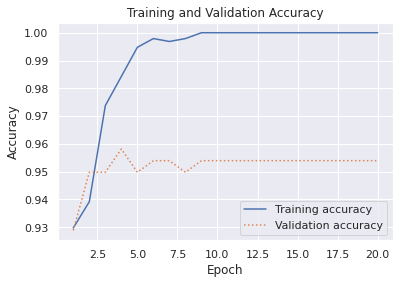

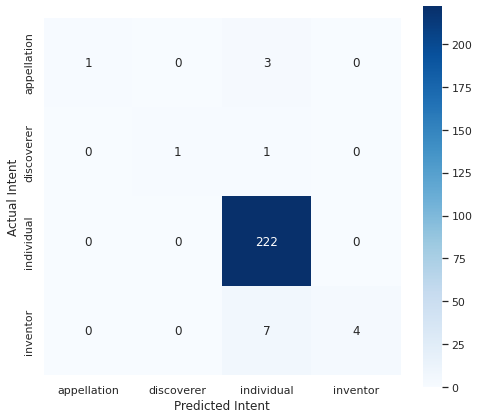

In [281]:
# ['individual' 'inventor' 'discoverer' 'appellation' 'group' 'other']
coarse_type='person';
fine_types=['individual','inventor','discoverer','appellation']
epoch=20
learning_rate=0.002
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate)

**Organization**

59
Epoch 1/50
3/3 [==============================] - 1s 115ms/step - loss: 1.1046 - categorical_accuracy: 0.3404 - val_loss: 1.0942 - val_categorical_accuracy: 0.4167
Epoch 2/50
3/3 [==============================] - 0s 23ms/step - loss: 1.0270 - categorical_accuracy: 0.4681 - val_loss: 1.0771 - val_categorical_accuracy: 0.5833
Epoch 3/50
3/3 [==============================] - 0s 23ms/step - loss: 1.0222 - categorical_accuracy: 0.6383 - val_loss: 1.0410 - val_categorical_accuracy: 0.6667
Epoch 4/50
3/3 [==============================] - 0s 27ms/step - loss: 0.9687 - categorical_accuracy: 0.7234 - val_loss: 1.0058 - val_categorical_accuracy: 0.4167
Epoch 5/50
3/3 [==============================] - 0s 24ms/step - loss: 0.8988 - categorical_accuracy: 0.5745 - val_loss: 0.9771 - val_categorical_accuracy: 0.4167
Epoch 6/50
3/3 [==============================] - 0s 25ms/step - loss: 0.8291 - categorical_accuracy: 0.5106 - val_loss: 0.9786 - val_categorical_accuracy: 0.4167
Epoch 7/50
3/3 [==

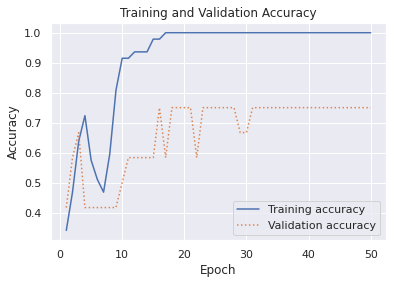

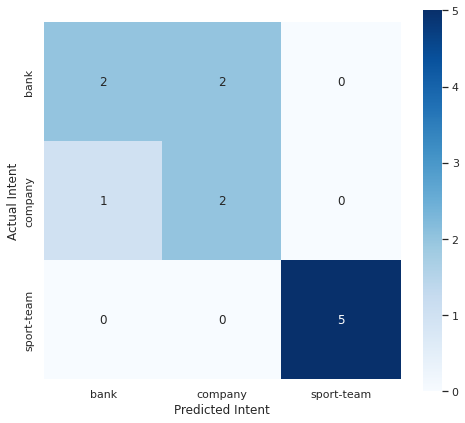

In [282]:
coarse_type='organization';
fine_types=['sport-team','bank','company']
epoch=50
learning_rate=0.002
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate)

**Location**

630
Epoch 1/30
23/23 [==============================] - 1s 22ms/step - loss: 1.5615 - categorical_accuracy: 0.4107 - val_loss: 1.4150 - val_categorical_accuracy: 0.4762
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 1.1478 - categorical_accuracy: 0.6429 - val_loss: 1.0900 - val_categorical_accuracy: 0.6587
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.6563 - categorical_accuracy: 0.7996 - val_loss: 0.8653 - val_categorical_accuracy: 0.6825
Epoch 4/30
23/23 [==============================] - 0s 13ms/step - loss: 0.3442 - categorical_accuracy: 0.9028 - val_loss: 0.7676 - val_categorical_accuracy: 0.7381
Epoch 5/30
23/23 [==============================] - 0s 13ms/step - loss: 0.1643 - categorical_accuracy: 0.9643 - val_loss: 0.8408 - val_categorical_accuracy: 0.7381
Epoch 6/30
23/23 [==============================] - 0s 12ms/step - loss: 0.0882 - categorical_accuracy: 0.9841 - val_loss: 0.7999 - val_categorical_accuracy: 0.7460
Epoch 

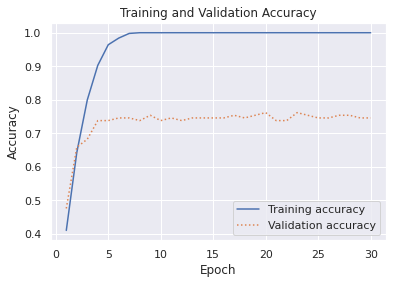

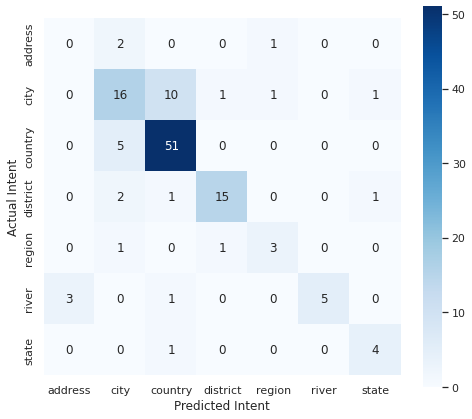

In [283]:
coarse_type='location';
fine_types=['country','city','district','river','region','state','address']
epoch=30
learning_rate=0.003
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate)

**Temporal**

525
Epoch 1/30
20/20 [==============================] - 1s 21ms/step - loss: 1.3353 - categorical_accuracy: 0.5762 - val_loss: 1.1952 - val_categorical_accuracy: 0.5810
Epoch 2/30
20/20 [==============================] - 0s 12ms/step - loss: 0.9420 - categorical_accuracy: 0.6643 - val_loss: 0.8703 - val_categorical_accuracy: 0.7238
Epoch 3/30
20/20 [==============================] - 0s 13ms/step - loss: 0.4941 - categorical_accuracy: 0.8429 - val_loss: 0.7360 - val_categorical_accuracy: 0.7333
Epoch 4/30
20/20 [==============================] - 0s 12ms/step - loss: 0.2658 - categorical_accuracy: 0.9238 - val_loss: 0.6445 - val_categorical_accuracy: 0.7619
Epoch 5/30
20/20 [==============================] - 0s 12ms/step - loss: 0.1083 - categorical_accuracy: 0.9929 - val_loss: 0.5885 - val_categorical_accuracy: 0.7905
Epoch 6/30
20/20 [==============================] - 0s 12ms/step - loss: 0.0369 - categorical_accuracy: 0.9976 - val_loss: 0.5979 - val_categorical_accuracy: 0.7810
Epoch 

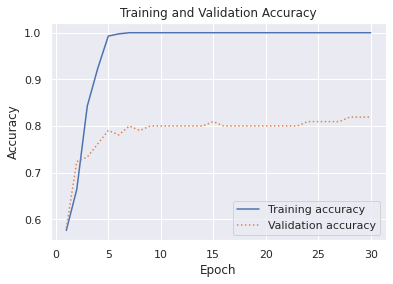

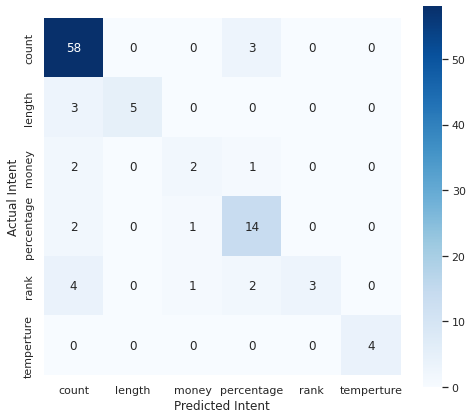

In [284]:
coarse_type='numerical';
fine_types= ['count','percentage','rank','length','money','temperture']
epoch=30
learning_rate=0.003
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate)

**Explanation**

161
Epoch 1/10
6/6 [==============================] - 1s 80ms/step - loss: 0.5287 - categorical_accuracy: 0.8828 - val_loss: 0.4533 - val_categorical_accuracy: 0.9091
Epoch 2/10
6/6 [==============================] - 0s 26ms/step - loss: 0.3926 - categorical_accuracy: 0.8906 - val_loss: 0.4618 - val_categorical_accuracy: 0.9091
Epoch 3/10
6/6 [==============================] - 0s 28ms/step - loss: 0.3785 - categorical_accuracy: 0.8906 - val_loss: 0.3334 - val_categorical_accuracy: 0.9091
Epoch 4/10
6/6 [==============================] - 0s 28ms/step - loss: 0.3000 - categorical_accuracy: 0.8906 - val_loss: 0.3182 - val_categorical_accuracy: 0.9091
Epoch 5/10
6/6 [==============================] - 0s 24ms/step - loss: 0.1979 - categorical_accuracy: 0.9141 - val_loss: 0.3263 - val_categorical_accuracy: 0.9091
Epoch 6/10
6/6 [==============================] - 0s 23ms/step - loss: 0.1368 - categorical_accuracy: 0.9766 - val_loss: 0.2925 - val_categorical_accuracy: 0.9091
Epoch 7/10
6/6 [==

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


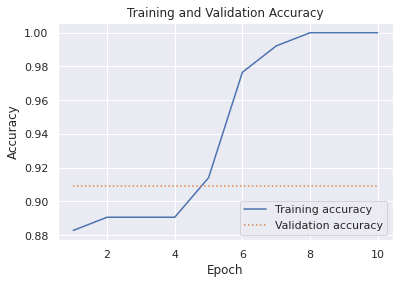

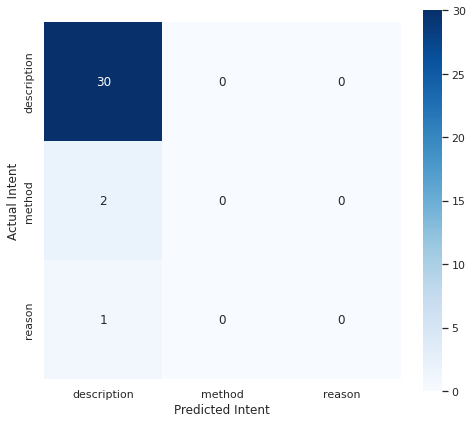

In [286]:
coarse_type='explanation';
fine_types= ['description','method','reason']
epoch=10
learning_rate=0.003
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate)

**Miscellaneous**

222
Epoch 1/30
9/9 [==============================] - 1s 43ms/step - loss: 2.1987 - categorical_accuracy: 0.2373 - val_loss: 2.0459 - val_categorical_accuracy: 0.3333
Epoch 2/30
9/9 [==============================] - 0s 14ms/step - loss: 1.8644 - categorical_accuracy: 0.4576 - val_loss: 1.8036 - val_categorical_accuracy: 0.4444
Epoch 3/30
9/9 [==============================] - 0s 14ms/step - loss: 1.2189 - categorical_accuracy: 0.6780 - val_loss: 1.4534 - val_categorical_accuracy: 0.5333
Epoch 4/30
9/9 [==============================] - 0s 15ms/step - loss: 0.6562 - categorical_accuracy: 0.8418 - val_loss: 1.1630 - val_categorical_accuracy: 0.5778
Epoch 5/30
9/9 [==============================] - 0s 16ms/step - loss: 0.3513 - categorical_accuracy: 0.9096 - val_loss: 1.0184 - val_categorical_accuracy: 0.6444
Epoch 6/30
9/9 [==============================] - 0s 16ms/step - loss: 0.1205 - categorical_accuracy: 0.9944 - val_loss: 0.9449 - val_categorical_accuracy: 0.6889
Epoch 7/30
9/9 [==

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


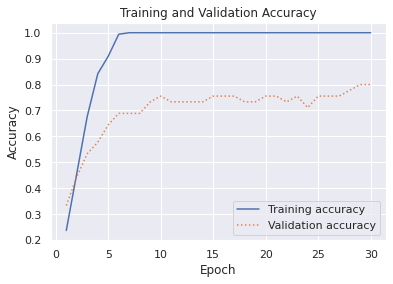

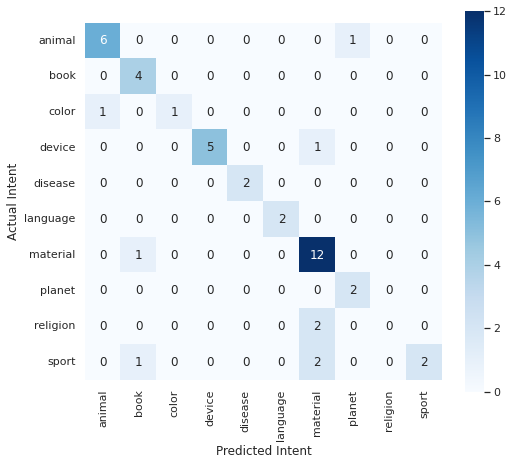

In [287]:
coarse_type='miscellaneous';
fine_types= ['material','animal','device','sport','book','planet','color','religion','disease','language']
epoch=30
learning_rate=0.007
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate)